In [1]:
print("hello world")

hello world


In [3]:
from google.colab import files

In [4]:
uploaded = files.upload()

Saving kaggle (10).json to kaggle (10).json


In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [7]:
!ls -l

total 8
-rw-r--r-- 1 root root   71 Apr 19 07:36 'kaggle (10).json'
drwxr-xr-x 1 root root 4096 Apr 17 13:36  sample_data


In [8]:
!mv 'kaggle (10).json' kaggle.json

In [9]:
import os

# Create the .kaggle directory if it does not exist
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the renamed kaggle.json file to the .kaggle directory
!mv kaggle.json /root/.kaggle/

In [10]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d bittlingmayer/amazonreviews


Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown


In [12]:

import os

# Print the current working directory
print(os.getcwd())

/content


In [13]:
!unzip amazonreviews.zip

Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [33]:
import pandas as pd
import numpy as np
import re
import nltk
import bz2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import TextVectorization  # Updated import for TextVectorization
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

nltk.download('stopwords')
nltk.download('wordnet')  # Fixed download from 'stopwords' to 'wordnet' to include lemmatizer

# Suppress warnings
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Set visualization styles
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
np.random.seed(2024)

# Check TensorFlow version
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.18.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# Load Data (limit to 20000 for speed, increase for performance)
def load_amazon_reviews(file_path, max_lines=20000):
    data = []
    with bz2.open(file_path, 'rt') as file:
        for i, line in enumerate(file):
            if i >= max_lines: break
            label, text = int(line[9]) - 1, line[10:].strip()
            data.append((label, text))
    return pd.DataFrame(data, columns=["label", "review"])

df = load_amazon_reviews("train.ft.txt.bz2")
df.head()


,label,review
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."


In [20]:
# Clean text
def clean_text(text):
    # Remove URLs & HTML
    text = re.sub(r"http\S+|www\S+|<.*?>", "", text)
    # Keep letters only and convert to lower case
    text = re.sub(r"[^a-zA-Z']", " ", text.lower())
    return re.sub(r"\s+", " ", text).strip()          # remove extra spaces

# Lemmatization and Stopword Removal
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Clean the text
    text = clean_text(text)
    # Lemmatize and remove stopwords
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df["review"] = df["review"].apply(preprocess_text)
df.head()


,label,review
0,1,stuning even non gamer sound track beautiful p...
1,1,best soundtrack ever anything reading lot revi...
2,1,amazing soundtrack favorite music time hand in...
3,1,excellent soundtrack truly like soundtrack enj...
4,1,remember pull jaw floor hearing played game kn...


In [26]:
# Load Data (limit to 20000 for speed, increase for performance)
def load_amazon_reviews(file_path, max_lines=20000):
    data = []
    with bz2.open(file_path, 'rt') as file:
        for i, line in enumerate(file):
            if i >= max_lines: break
            label, text = int(line[9]) - 1, line[10:].strip()
            data.append((label, text))
    return pd.DataFrame(data, columns=["label", "review"])

df = load_amazon_reviews("train.ft.txt.bz2")


In [27]:
# Clean text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|<.*?>", "", text)  # remove URLs & HTML
    text = re.sub(r"[^a-zA-Z']", " ", text.lower())   # keep letters only
    return re.sub(r"\s+", " ", text).strip()          # remove extra spaces

df["review"] = df["review"].apply(clean_text)


In [28]:
# Tokenize
max_words = 10000
max_len = 150

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df["review"])
sequences = tokenizer.texts_to_sequences(df["review"])
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y = np.array(df["label"])


In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Class weight for imbalance
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(weights))


In [34]:
# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [35]:
# Model: CNN + LSTM
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(32)),  # Reduced LSTM size to avoid overfitting
    Dropout(0.5),              # Dropout to prevent overfitting
    Dense(64, activation='relu'),  # Added more dense layers
    Dropout(0.5),              # Dropout to prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [36]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stop],  # Use EarlyStopping to prevent overfitting
    verbose=2
)


Epoch 1/5
225/225 - 28s - 126ms/step - accuracy: 0.7321 - loss: 0.4958 - val_accuracy: 0.8863 - val_loss: 0.2788
Epoch 2/5
225/225 - 41s - 182ms/step - accuracy: 0.9202 - loss: 0.2222 - val_accuracy: 0.8956 - val_loss: 0.2609
Epoch 3/5
225/225 - 25s - 110ms/step - accuracy: 0.9585 - loss: 0.1255 - val_accuracy: 0.8900 - val_loss: 0.2890
Epoch 4/5
225/225 - 40s - 177ms/step - accuracy: 0.9755 - loss: 0.0775 - val_accuracy: 0.8813 - val_loss: 0.3247


In [37]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")


125/125 - 4s - 29ms/step - accuracy: 0.8885 - loss: 0.2831
Test Accuracy: 0.8885


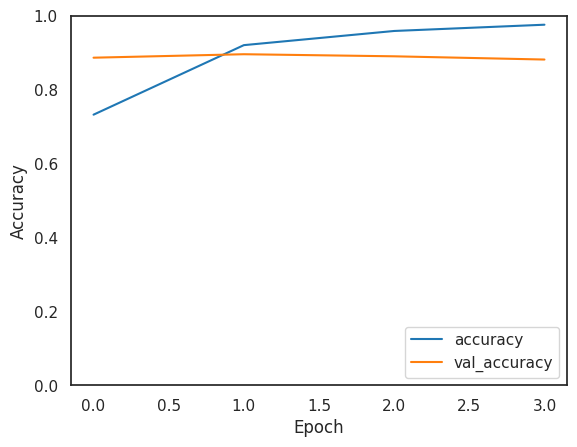

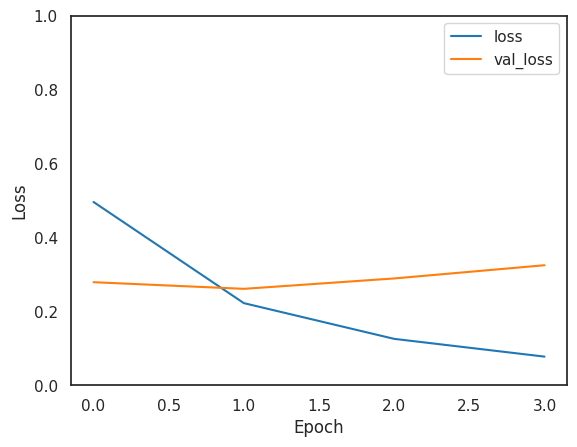

In [39]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()


In [40]:
# Predict on the test set
y_pred = model.predict(X_test, batch_size=64)

# Convert predictions to binary labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype("int32")

# Evaluate performance on test set
test_accuracy = accuracy_score(y_test, y_pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_labels, average='binary')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step
Test Accuracy: 0.8885
Precision: 0.9179
Recall: 0.8690
F1 Score: 0.8928


Confusion Matrix:
[[1697  166]
 [ 280 1857]]


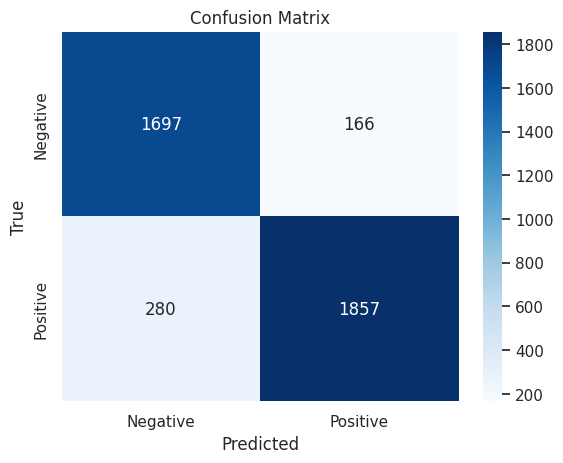

In [42]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [46]:
# Example: Predict sentiment of a new review
new_review = ["I don't love this product! it's not  amazing."]
new_review_cleaned = [clean_text(review) for review in new_review]
new_review_seq = tokenizer.texts_to_sequences(new_review_cleaned)
new_review_pad = pad_sequences(new_review_seq, maxlen=max_len, padding='post', truncating='post')

# Predict sentiment
prediction = model.predict(new_review_pad)
print(f"Prediction: {'Positive' if prediction > 0.5 else 'Negative'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: Positive


In [47]:
# Predict sentiment and check the probability
prediction_prob = model.predict(new_review_pad)
print(f"Prediction Probability: {prediction_prob[0][0]:.4f}")
print(f"Prediction: {'Positive' if prediction_prob > 0.5 else 'Negative'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction Probability: 0.8889
Prediction: Positive


In [57]:
new_review = ["This product is terrible. I hate it and want a refund."]


In [61]:
# Sample reviews for sentiment prediction
test_reviews = [
    "Absolutely terrible product. I hated it!",
    "This is the best thing I've ever bought. Totally worth it!",
    "Not bad, but definitely could be better.",
    "I love how this works. Great job!",
    "Meh. It's okay, nothing special."
]

# Step 1: Preprocess reviews (clean, tokenize, pad)
cleaned = [clean_text(r) for r in test_reviews]
sequences = tokenizer.texts_to_sequences(cleaned)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Step 2: Predict sentiment probabilities
predicted_probs = model.predict(padded)

# Step 3: Calculate optimal threshold from validation set (if not done earlier)
from sklearn.metrics import precision_recall_curve

val_probs = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, val_probs)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold = thresholds[np.argmax(f1)]

# Step 4: Print predictions using the dynamic threshold
print(f"Optimal Dynamic Threshold: {best_threshold:.4f}\n")

for i, prob in enumerate(predicted_probs):
    sentiment = "Positive" if prob > best_threshold else "Negative"
    print(f"Review {i+1}: {test_reviews[i]}")
    print(f"→ Probability: {prob[0]:.4f}")
    print(f"→ Prediction: {sentiment}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Optimal Dynamic Threshold: 0.2656

Review 1: Absolutely terrible product. I hated it!
→ Probability: 0.0069
→ Prediction: Negative

Review 2: This is the best thing I've ever bought. Totally worth it!
→ Probability: 0.9464
→ Prediction: Positive

Review 3: Not bad, but definitely could be better.
→ Probability: 0.2692
→ Prediction: Positive

Review 4: I love how this works. Great job!
→ Probability: 0.9916
→ Prediction: Positive

Review 5: Meh. It's okay, nothing special.
→ Probability: 0.0898
→ Prediction: Negative

